In [1]:
# Samantha Hong sh974
# ECE 4250 Assignment 4
import numpy as np
import scipy
from scipy import ndimage
from scipy import signal
import scipy.io as sio
import scipy.io.wavfile
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# 1. Histogram Equalization

   ## Basic Histogram Equalization Algorithm

In [2]:
def make_hist(img):
    hist = np.zeros(256, dtype=int)
    for i in range(img.size):
        hist[img[i]] += 1
    return hist

def cumulative_sum(hist):
    cumsum = np.zeros(256, dtype=int)
    cumsum[0] = hist[0]
    for i in range(1, hist.size):
        cumsum[i] = cumsum[i-1] + hist[i]
    return cumsum

def map_values(img, cumsum):
    mapping = np.zeros(256, dtype=int)
    for i in range(256):
        mapping[i] = max(0, round((cumsum[i])/256-1))
                         
    new_image = np.zeros(img.size, dtype=int)
    for i in range(img.size):
        new_image[i] = mapping[img[i]]
    return new_image

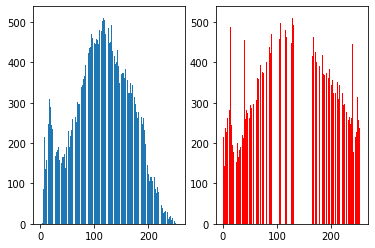

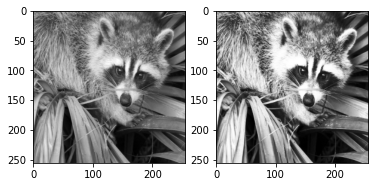

In [3]:
file = "X.png"
out_file = "X_histeq.png"

# Load image, store width and height into constants
img = Image.open(file)
orig = img
w, h = img.size

img = np.array(img).flatten()
histogram = make_hist(img)
cumsum = cumulative_sum(histogram)
img_histeq = map_values(img, cumsum)

output_image = Image.fromarray(np.uint8(img_histeq.reshape((w, h))))
output_image.save(out_file)

x_axis = np.arange(256)
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.bar(x_axis, histogram)
fig.add_subplot(1, 2, 2)
plt.bar(x_axis, make_hist(img_histeq), color="red")
plt.show()

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(orig, cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.show()


   ## Exact Histogram Equalization Algorithm

In [4]:
# filter masks
m1 = 1./5 * np.array([[0, 1, 0],
                      [1, 1, 1],
                      [0, 1, 0]])

m2 = 1./9 * np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]])

m3 = 1./13 * np.array([[0, 0, 1, 0, 0],
                       [0, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 0],
                       [0, 0, 1, 0, 0]])

m4 = 1./21 * np.array([[0, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 0]])

m5 = 1./25 * np.array([[1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1]])

In [9]:
def exact_hist(img): 
    img = np.asarray(img.convert('L'))
    flattened_img = img.flatten()
    width, height = img.shape

    image = np.array(img).flatten()
    masks = [m1, m2, m3, m4, m5]
    
    # convolve all masks and img
    conv_masks = np.array([signal.convolve2d(img, mask, 'same') for mask in masks])
    
    # flatten and then lexicographically sort
    conv_masks = [mask.flatten() for mask in conv_masks]
    sorted_pixels = np.lexsort((conv_masks[0], conv_masks[1], conv_masks[2], conv_masks[3], conv_masks[4], image))

    # split ordered pixels into 256 different groups
    groups = np.split(sorted_pixels, 256)
    
    # assign intensity value j to pixels in group j
    for i in range(len(groups)): 
        group = groups[i]
        for j in range(len(group)):
            flattened_img[group[j]] = i
    
    return flattened_img.reshape((256, 256))

[61611 59562 58538 ... 22157 24478 21389]


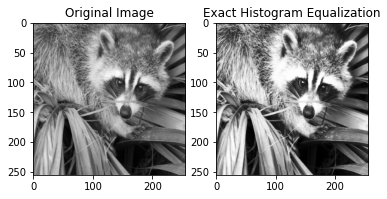

In [10]:
img = Image.open(file)
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
fig.add_subplot(1, 2, 2)
plt.imshow(exact_hist(img), cmap='gray')
plt.title('Exact Histogram Equalization')
plt.show()

# 2. Spatial Transformations

## Rotate2D


In [62]:
def Rotate2D(img, angle):
    width, height = img.shape
    theta = np.radians(-1*angle)
    cos, sin = np.cos(theta), np.sin(theta)
    rotated_img = np.zeros((width, height), dtype=int)
    
    to_center = np.array([[1, 0, width/2], [0, 1, height/2], [0, 0, 1]])
    from_center = np.array([[1, 0, -width/2], [0, 1, -height/2], [0, 0, 1]])
    matrix = np.array([[cos, -sin, 0], [sin, cos, 0], [0, 0, 1]])
    rotation_matrix = np.dot(np.dot(to_center, matrix), from_center)

    
    for i in range(width):
        for j in range(height):
            pixel = np.dot(rotation_matrix, [i, j, 1])
            if -1 < pixel[0] < width and -1 < pixel[1] < height: 
                rotated_img[i][j] = img[int(pixel[0])][int(pixel[1])] 

    return rotated_img

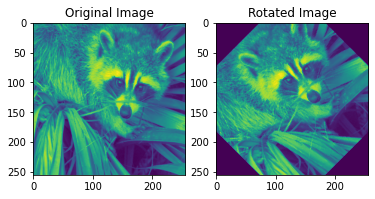

In [63]:
img = Image.open(file)
x = np.asarray(img.convert('L'))

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
fig.add_subplot(1, 2, 2)
plt.imshow(Rotate2D(x, 45))
plt.title('Rotated Image')
plt.show()

## Translate2D

In [65]:
def Translate2D(img, translation):
    width, height = img.shape
    c, r = translation
    translated_img = np.zeros((width, height), dtype=int)

    translated_matrix = np.array([[1, 0, -r], [0, 1, -c]])
    
    for i in range(width):
        for j in range(height):
            pixel = np.dot(translated_matrix, [i, j, 1])
            if -1 < pixel[0] < width and -1 < pixel[1] < height: 
                translated_img[i][j] = img[int(pixel[0])][int(pixel[1])] 

    return translated_img

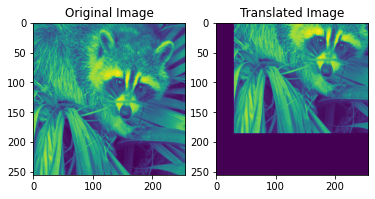

In [66]:
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
fig.add_subplot(1, 2, 2)
plt.imshow(Translate2D(x, [30, -70]))
plt.title('Translated Image')
plt.show()